In [33]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.applications.resnet50 import preprocess_input
#from keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import ImageDataGenerator
import pandas as pd 
import numpy as np 
import os 
from matplotlib import pyplot as plt
from math import ceil

In [2]:
# get attractiveness ratings for each image 
ratings_df = pd.read_excel("../CFD 2 Codebook.xlsx")
ratings_df["Attractiveness"] = (ratings_df["Attractive"]-ratings_df["Attractive"].mean())/ratings_df["Attractive"].std()

#attractiveness_dict = ratings_df.set_index('Target')['Attractiveness'].to_dict() 

attractiveness_df = ratings_df[["Target","Attractiveness"]]
display(attractiveness_df.head())

,Target,Attractiveness
0,AF-200,1.143804
1,AF-201,-0.157090
2,AF-202,-0.301633
3,AF-203,0.057234
4,AF-204,-0.077341


In [3]:
# Prepare dataframe to feed in to imagedatagenerator 

image_files = os.listdir('C:/Users/Shoya/Aphrodite/All CFD Images/')

image_df = pd.DataFrame(image_files, columns=["Image File Names"])
image_df["Target ID"] = image_df["Image File Names"].str.slice(4,10)
data_df = pd.merge(image_df, attractiveness_df, left_on="Target ID", right_on="Target")[["Image File Names","Target ID","Attractiveness"]]
data_df = data_df.sample(frac=1).reset_index(drop=True)


In [4]:
data_df.head()

,Image File Names,Target ID,Attractiveness
0,CFD-WM-022-012-F.jpg,WM-022,-0.443035
1,CFD-BF-008-012-A.jpg,BF-008,-0.211917
2,CFD-BF-009-008-HC.jpg,BF-009,-0.598577
3,CFD-BF-212-315-N.jpg,BF-212,1.779797
4,CFD-LM-234-176-N.jpg,LM-234,0.180179


In [5]:
data_df.describe()

,Attractiveness
count,1207.000000
mean,-0.051699
std,0.965902
min,-2.226956
25%,-0.701908
50%,-0.201565
75%,0.586782
max,2.922321


In [6]:
train_df = data_df.iloc[:1020]
test_df = data_df.iloc[1020:]

In [50]:
# Make Model 

base_model = ResNet50(include_top=False, pooling='avg')
model = Sequential()
model.add(base_model)
model.add(Dense(512,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(1,))
model.layers[0].trainable=False 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 24,768,385
Trainable params: 1,180,673
Non-trainable params: 23,587,712
_________________________________________________________________


In [51]:
# Make ImageDataGenerator 

train_datagen= ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator=train_datagen.flow_from_dataframe(
                                                dataframe=train_df,
                                                directory= 'C:/Users/Shoya/Aphrodite/All CFD Images/',
                                                x_col='Image File Names',
                                                y_col='Attractiveness',
                                                class_mode='other'
                                                )

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
                                                dataframe=test_df,
                                                directory= 'C:/Users/Shoya/Aphrodite/All CFD Images/',
                                                x_col='Image File Names',
                                                y_col='Attractiveness',
                                                class_mode='other'
                                                )


Found 1020 images.
Found 187 images.


In [52]:
# Compile Model 
model.compile(optimizer='Adam',loss='mean_squared_error',metrics=['mse'])

In [77]:
n_train = len(train_generator.filenames)
n_test = len(test_generator.filenames)

steps_per_epoch_train = ceil(n_train/32) # batch_size of 32 used as default 
steps_per_epoch_test = ceil(n_test/32)

history = model.fit_generator(generator=train_generator,steps_per_epoch=steps_per_epoch_train, epochs=5,validation_data=test_generator, validation_steps=steps_per_epoch_test)

Epoch 1/5
32/32 [==============================] - 1064s 33s/step - loss: 0.5074 - mean_squared_error: 0.5077 - val_loss: 0.4719 - val_mean_squared_error: 0.4752
Epoch 2/5
32/32 [==============================] - 1238s 39s/step - loss: 0.3692 - mean_squared_error: 0.3691 - val_loss: 0.5870 - val_mean_squared_error: 0.5901
Epoch 3/5
32/32 [==============================] - 1247s 39s/step - loss: 0.5314 - mean_squared_error: 0.5322 - val_loss: 0.4753 - val_mean_squared_error: 0.4742
Epoch 4/5
32/32 [==============================] - 1215s 38s/step - loss: 0.3996 - mean_squared_error: 0.3981 - val_loss: 0.3769 - val_mean_squared_error: 0.3736
Epoch 5/5
32/32 [==============================] - 1039s 32s/step - loss: 0.2682 - mean_squared_error: 0.2679 - val_loss: 0.4643 - val_mean_squared_error: 0.4608


dict_keys(['mean_squared_error', 'val_loss', 'val_mean_squared_error', 'loss'])


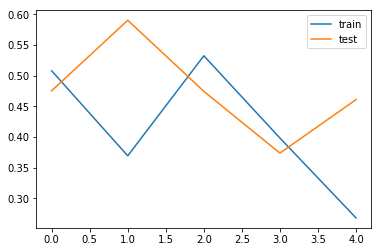

In [78]:
print(history.history.keys())
plt.plot(history.history['mean_squared_error'],label="train")
plt.plot(history.history['val_mean_squared_error'],label="test")
plt.legend()
plt.show();

In [64]:
loss = model.evaluate_generator(generator=test_generator)

In [65]:
print(loss)

[1.4136118193467457, 1.4282455]


In [79]:
# Now Prepare Employee 

goldman_image_files = os.listdir('C:/Users/Shoya/Aphrodite/Goldman Employees/photos_cropped/')
rbc_image_files = os.listdir('C:/Users/Shoya/Aphrodite/RBC Employees/photos_cropped/')

goldman_df = pd.DataFrame(goldman_image_files, columns=["Image File Names"])
goldman_df["class"] = np.nan

# You know I had to try.... 
goldman_df.append({"Image File Names":"Shoya.jpeg","class":np.nan},ignore_index=True)

rbc_df = pd.DataFrame(rbc_image_files, columns=["Image File Names"])
rbc_df["class"] = np.nan

In [80]:
goldman_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

goldman_generator = goldman_datagen.flow_from_dataframe(
                                                dataframe=goldman_df,
                                                directory= 'C:/Users/Shoya/Aphrodite/Goldman Employees/photos_cropped/',
                                                x_col='Image File Names',
                                                batch_size=1,
                                                class_mode='other'
                                                )
rbc_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

rbc_generator = rbc_datagen.flow_from_dataframe(
                                                dataframe=rbc_df,
                                                directory= 'C:/Users/Shoya/Aphrodite/RBC Employees/photos_cropped/',
                                                x_col='Image File Names',
                                                batch_size=1,
                                                class_mode='other'
                                                )



Found 76 images.
Found 52 images.


In [81]:
n_goldman = len(goldman_generator.filenames)
n_rbc = len(rbc_generator.filenames) 

In [82]:
goldman_predictions = model.predict_generator(goldman_generator,steps=n_goldman)
rbc_predictions = model.predict_generator(rbc_generator,steps=n_rbc)

In [83]:
goldman_df["Pred"] = goldman_predictions
rbc_df["Pred"] = rbc_predictions

In [84]:
goldman_df.describe()

,class,Pred
count,0.0,76.000000
mean,NaN,0.031874
std,NaN,0.776052
min,NaN,-2.637702
25%,NaN,-0.338865
50%,NaN,-0.025073
75%,NaN,0.499471
max,NaN,1.500715


In [85]:
rbc_df.describe()

,class,Pred
count,0.0,52.000000
mean,NaN,0.375627
std,NaN,0.651346
min,NaN,-0.816990
25%,NaN,-0.144072
50%,NaN,0.399802
75%,NaN,0.731252
max,NaN,1.880518


In [88]:
#goldman_df.sort_values("Pred", ascending=False)

In [89]:
#rbc_df.sort_values("Pred",ascending=False)

In [72]:
#goldman_df.to_excel("Goldman Predictions.xlsx")